<a href="https://colab.research.google.com/github/ni-chen/Differentiable-Imaging/blob/main/code/differentiable_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Differentiablilty

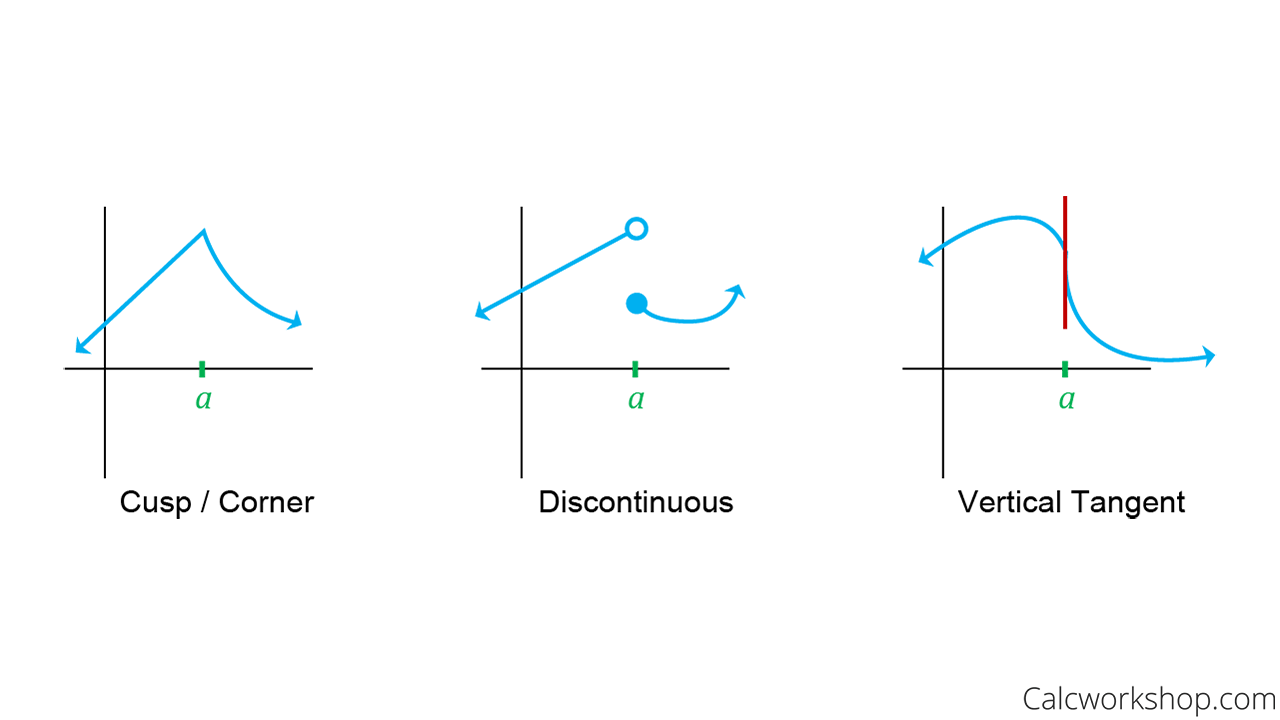

All differentiable functions must therefore be continuous, but not all continuous functions are differentiable!

$$
f(x) = |x| =
\begin{cases}
-x, && x<0 \\
x, && x>= 0
\end{cases}
$$


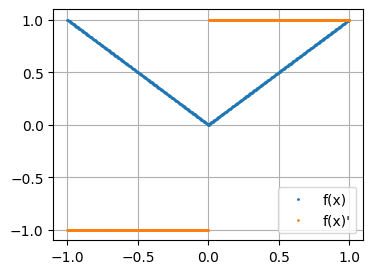

In [159]:
x = torch.linspace(-1, 1, 500, requires_grad=True)

y = torch.abs(x)
loss = y.sum()
loss.backward()

fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharey=False)
ax.plot(x.detach(), y.data, '.', label='f(x)')
ax.plot(x.detach(), x.grad, '.', label='f(x)\'')
ax.grid()
ax.legend()

## Non-differentiable in PyTorch

- indexing cannot be differentiable wrt their indices and some inputs
- integer spaces are not differentiable
- Discontinous function's derivatives are zero
- Complex numbers

### Discontinous functions

In PyTorch, discontious functions such as round(), ceil(), floor(), etc, returns $0$ derivatives.

In [105]:
import torch

x = torch.tensor([0.5, 2.5], requires_grad=True)

y = torch.round(x)

loss = y.sum()
loss.backward()

# print(y.grad_fn)
print(f"Derivative at x is {x.grad}")

Derivative at x is tensor([0., 0.])


In [106]:
x = torch.tensor([0.5, 2.5], requires_grad=True)

y = torch.floor(x)

loss = y.sum()
loss.backward()

# print(y.grad_fn)
print(f"Derivative at x is {x.grad}")

Derivative at x is tensor([0., 0.])


In [107]:
x = torch.tensor([0.5, 2.5], requires_grad=True)

y = torch.ceil(x)

loss = y.sum()
loss.backward()

# print(y.grad_fn)
print(f"Derivative at x is {x.grad}")

Derivative at x is tensor([0., 0.])


In [ ]:
a = torch.tensor([0.], requires_grad=True)
b = a.sqrt()
b = b.clone()
b[0] = 0
b.backward()
# `a.grad` is `nan` but expected `0`
print(a.grad)

$|x|$ is discontious at $x=0$, PyTorch gives a derivative of $0$ at $x=0$.

In [108]:
x = torch.tensor([-1.0, 0.0, 1.5], requires_grad=True)

y = torch.abs(x)
loss = y.sum()
loss.backward()

# print(y.grad_fn)
print(f"Derivative at x is {x.grad}")

Derivative at x is tensor([-1.,  0.,  1.])


In [109]:
x = torch.tensor([2.0, 0.0, 1.5], requires_grad=True)
y = torch.maximum(x, torch.tensor(-1))

loss = y.sum()
loss.backward()

# print(y.grad_fn)
print(f"Derivative at x is {x.grad}")

Derivative at x is tensor([1., 1., 1.])


### Not implemented

In [111]:
x = torch.linspace(-1, 1, 200, requires_grad=True)

y = torch.heaviside(x, torch.tensor(0.5))
loss = y.sum()
loss.backward()

# print(y.grad_fn)
print(f"Derivative at x is {x.grad}")

RuntimeError: ignored

### NaN and Infinite

In [165]:
x = torch.tensor([0.], requires_grad=True)

y = x.sqrt()
y.backward()

print(f"Derivative at x is {x.grad}")

Derivative at x is tensor([inf])


In [166]:
x = torch.randn(1, requires_grad=True)
y = x / 0.

loss = y.sum()
loss.backward()

print(f"Derivative at x is {x.grad}")

Derivative at x is tensor([inf])


In [167]:
x = torch.randn(1, requires_grad=True)
y = x / 0.
y = y / y

loss = y.sum()
loss.backward()

print(f"Derivative at x is {x.grad}")

Derivative at x is tensor([nan])


The forward generates inf, typical examples:
- torch.log(x) when x approaches to 0
- torch.exp(x) when x is very large
- x/0



References:
- https://github.com/pytorch/pytorch/issues/4132

In [114]:
x = torch.tensor([0., 1., 100.], requires_grad=True)

y = x.exp().log1p()
loss = y.sum()
loss.backward()

print(f"Derivative at x is {x.grad}")

Derivative at x is tensor([0.5000, 0.7311,    nan])


In [115]:
class Log1PlusExp(torch.autograd.Function):
     """Implementation of x ↦ log(1 + exp(x))."""
     @staticmethod
     def forward(ctx, x):
         exp = x.exp()
         ctx.save_for_backward(x)
         return x.where(torch.isinf(exp), exp.log1p())

     @staticmethod
     def backward(ctx, grad_output):
         x, = ctx.saved_tensors
         return grad_output / (1 + (-x).exp())

log_1_plus_exp = Log1PlusExp.apply

x = torch.tensor([0., 1., 100.], requires_grad=True)
y = log_1_plus_exp(x)
loss = y.sum()
loss.backward()

print(f"Derivative at x is {x.grad}")

Derivative at x is tensor([0.5000, 0.7311, 1.0000])


In [102]:
import torch

x = torch.tensor([1.,1], requires_grad=True)
div = torch.tensor([0.,1])
y = x/div             # => y is [inf, 1]
zero_mask = (div==0)  # => zero_mask is [1, 0]
y[zero_mask] = 0      # => y is [0, 1]

loss = y.sum()
loss.backward()

print(f'y is {y.data.numpy()}')
print(f'x grad is {x.grad.numpy()}')

y is [0. 1.]
x grad is [nan  1.]


In [100]:
x = torch.tensor([1.,1], requires_grad=True)
div = torch.tensor([0.,1])

numerator=torch.tensor([0.,1])
one_mask = (div!=0) # => one_mask is [0, 1]
numerator[one_mask] = x[one_mask] /div[one_mask]
y = (numerator)
zero_mask = (div==0) # => zero_mask is [1, 0]
y[zero_mask] = 0  # => y is [0, 1]

loss = y.sum()
loss.backward()

print(f'y is {y.data.numpy()}')
print(f'x grad is {x.grad.numpy()}')

y is [0. 1.]
x grad is [0. 1.]


### Indexing

In [116]:
import torch

def non_diff_f(x):
    idx = x<0
    x[idx] = -1*x[idx]
    x[~idx] = x[~idx]**2

    return x

############### Test gradient ######################
x = torch.tensor([-2.0, -1.0, 0.0, 1.0, 2.0])
y = non_diff_f(x).sum()


x.requires_grad_()
y = non_diff_f(x)
loss = y.sum()
loss.backward()
print(y)
print(f"Derivative at x is {x.grad}")

tensor(8.)


RuntimeError: ignored

### Complex numbers

In [162]:
import torch

x = torch.tensor([-4.0], dtype=torch.complex128, requires_grad=True)
y = torch.sqrt(x)
loss = y.sum().abs()
loss.backward()

print(f"y is {y}")
print(f"Derivative at x is {x.grad}")


print('-------------------------------')

x = torch.tensor([-4.0], dtype=torch.float64, requires_grad=True)
y = torch.sqrt(x)
loss = y.sum()
loss.backward()

print(f"y is {y}")
print(f"Derivative at x is {x.grad}")

y is tensor([0.+2.j], dtype=torch.complex128, grad_fn=<SqrtBackward0>)
Derivative at x is tensor([-0.2500+0.j], dtype=torch.complex128)
-------------------------------
y is tensor([nan], dtype=torch.float64, grad_fn=<SqrtBackward0>)
Derivative at x is tensor([nan], dtype=torch.float64)


## Alternative differentiable functions

References
1. Adelta: Automatic Differentiation for Discontinuous Programs: https://github.com/yyuting/Adelta




### round()

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def diff_round1(x):
    return torch.round(x) - x.detach() + x


def diff_round2(x):
    return torch.round(x) + (x - torch.round(x))**3


def soft_round(x, alpha=15, eps=1e-3):
    """Differentiable approximation to `round`.

    Larger alphas correspond to closer approximations of the round function.
    If alpha is close to zero, this function reduces to the identity.

    This is described in Sec. 4.1. in the paper:
    - "Universally Quantized Neural Compression", Eirikur Agustsson & Lucas Theis, https://arxiv.org/abs/2006.09952

    x: `torch.Tensor`. Inputs to the rounding function.
    alpha: Float or `torch.Tensor`. Controls smoothness of the approximation.
    eps: Float. Threshold below which `soft_round` will return identity.

    """

    # This guards the gradient of tf.where below against NaNs, while maintaining
    # correctness, as for alpha < eps the result is ignored.
    alpha_bounded = torch.maximum(torch.as_tensor(alpha), torch.as_tensor(eps))

    m = torch.floor(x) + .5
    r = x - m
    z = torch.tanh(alpha_bounded / 2.) * 2.
    y = m + torch.tanh(alpha_bounded * r) / z

    # For very low alphas, soft_round behaves like identity
    return torch.where(torch.as_tensor(alpha < eps), x, y)


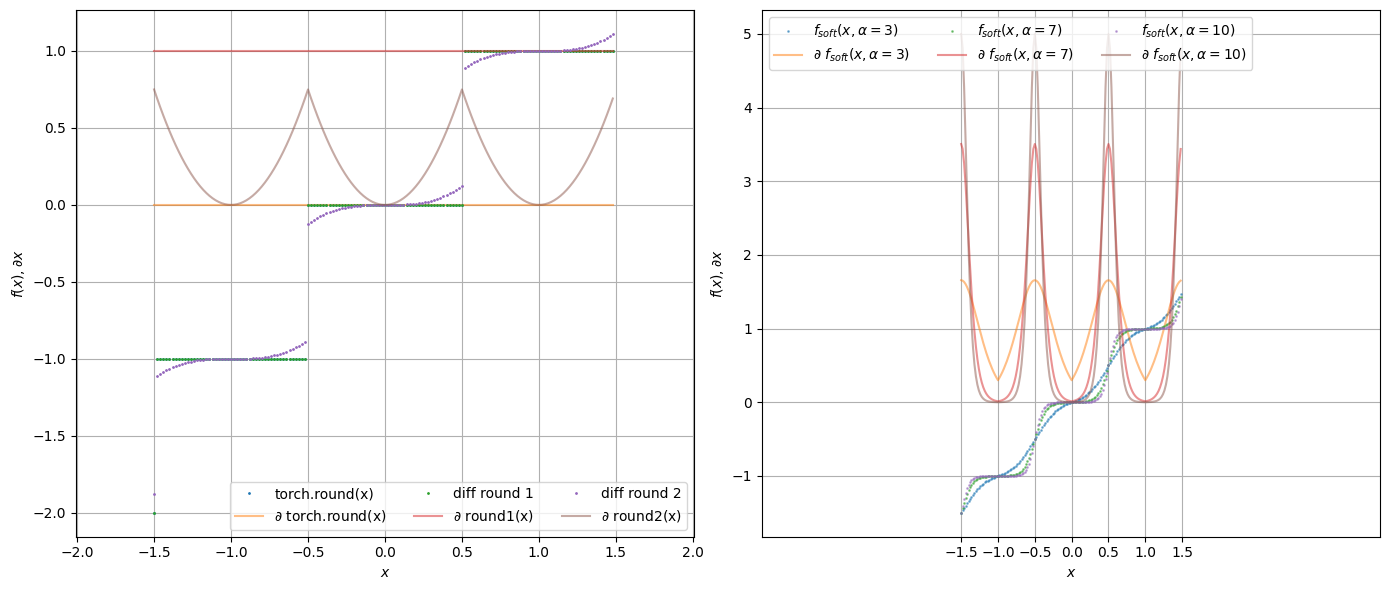

In [119]:
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 2


L = 1.5
dx = 0.02

fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

x = torch.from_numpy(np.arange(-L, L, dx).astype(np.float32))
ax[0].plot(x, torch.round(x), '.',  label=f'torch.round(x)')
x.requires_grad_()
y1 = torch.round(x)
loss = y1.sum()
loss.backward()
ax[0].plot(x.detach().numpy(), x.grad.detach().numpy(), '-', alpha=0.5, label=r'$\partial$ ' + f'torch.round(x)')


x = torch.from_numpy(np.arange(-L, L, dx).astype(np.float32))
ax[0].plot(x, diff_round1(x), '.', label=f'diff round 1')
x.requires_grad_()
y2 = diff_round1(x)
loss = y2.sum()
loss.backward()
ax[0].plot(x.detach().numpy(), x.grad.detach().numpy(), '-', alpha=0.5, label=r'$\partial$ ' + f'round1(x)')


x = torch.from_numpy(np.arange(-L, L, dx).astype(np.float32))
ax[0].plot(x, diff_round2(x), '.',  label=f'diff round 2')
x.requires_grad_()
y3 = diff_round2(x)
loss = y3.sum()
loss.backward()
ax[0].plot(x.detach().numpy(), x.grad.detach().numpy(), '-', alpha=0.5, label=r'$\partial$ ' + f'round2(x)')

ax[0].legend(loc='lower right', ncol = 3)
ax[0].axis('equal')
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$f(x), \partial x$')
ax[0].grid(True)
ax[0].set_xlim(-2.5,2.5)
ax[0].set_xticks(np.arange(-2, 2.5, 0.5))


for alpha in [3, 7, 10]:
    x = torch.from_numpy(np.arange(-L, L, dx).astype(np.float32))
    x.requires_grad_()

    y = soft_round(x, torch.tensor(alpha))
    ax[1].plot(x.detach().numpy(), y.detach().numpy(), '.', alpha=0.5, label=r'$f_{soft}(x, \alpha=$'+f'{alpha})')

    loss = y.sum()
    loss.backward()

    ax[1].plot(x.detach().numpy(), x.grad.detach().numpy(), '-', alpha=0.5, label=r'$\partial ~f_{soft}(x, \alpha=$'+f'{alpha})')

ax[1].legend(loc='upper left', ncol = 3)
ax[1].axis('equal')
ax[1].grid(True)
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$f(x), \partial x$')
ax[0].set_xlim(-2,2)
ax[1].set_xticks(np.arange(-1.5, 2, 0.5))

fig.tight_layout()
fig.show()


### circ()

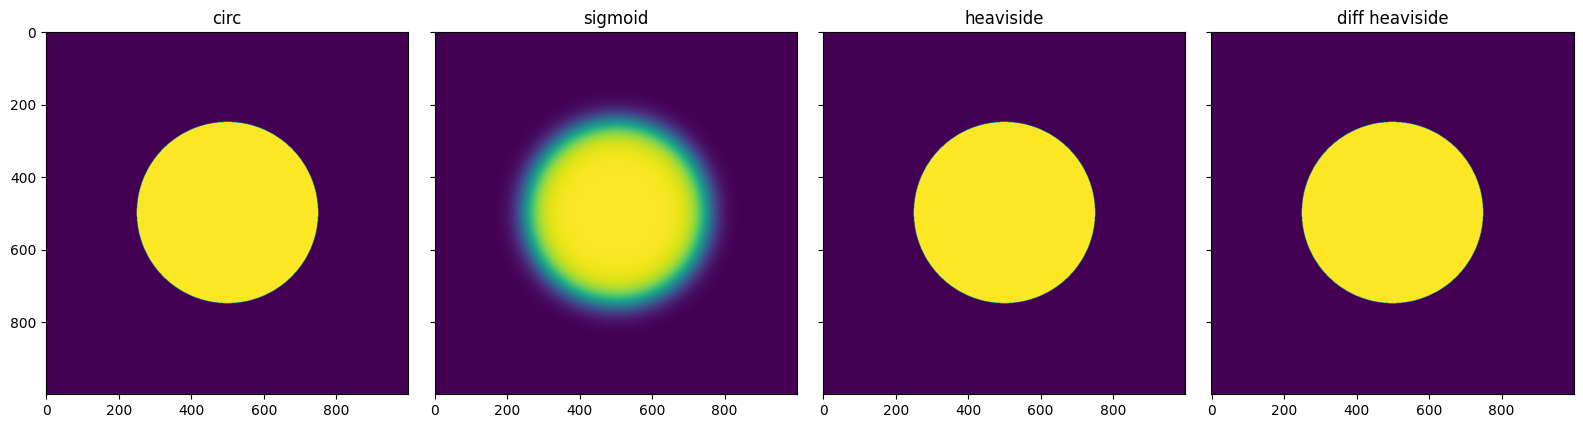

In [8]:
L = 5
N = 1000
x = torch.linspace(-L, L, N, dtype=torch.float64)
[x, y] = torch.meshgrid(x, x, indexing='ij')
x.requires_grad_()
r = torch.as_tensor(L/2)


fig, ax = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

c = ((x ** 2 + y**2)<= r ** 2).to(torch.float64)
ax[0].imshow(c.detach().numpy())
ax[0].set_title('circ')

c = torch.sigmoid(r ** 2 - (x ** 2 + y**2))
ax[1].imshow(c.detach().numpy())
ax[1].set_title('sigmoid')

c = torch.heaviside(r ** 2 - (x ** 2 + y**2), torch.as_tensor(0.5,dtype=torch.float64))
ax[2].imshow(c.detach().numpy())
ax[2].set_title('heaviside')


# def diff_heaviside(x, epsilon=1e-5):
#     return 0.5 * (1 + torch.tanh(x / epsilon))

# def diff_heaviside(x, epsilon=1e-6):
#     return (torch.sign(x) + 1) * 0.5 + (1 - torch.sign(torch.abs(x) - epsilon)) * 0.5

def diff_heaviside(x, epsilon=1e-6):
    return torch.sigmoid(2.0 / epsilon * x)

c = diff_heaviside(r ** 2 - (x ** 2 + y**2))
ax[3].imshow(c.detach().numpy())
ax[3].set_title('diff heaviside')


fig.tight_layout()
fig.show()

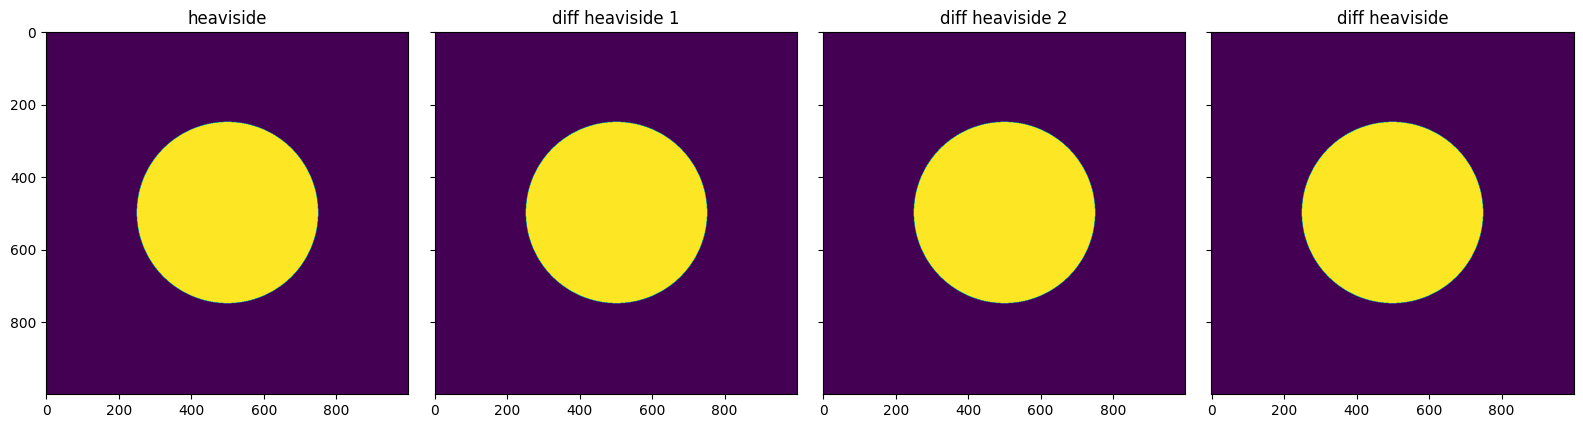

In [9]:
L = 10
N = 1000
x = torch.linspace(-L, L, N, dtype=torch.float64)
[x, y] = torch.meshgrid(x, x, indexing='ij')
x.requires_grad_()
r = torch.as_tensor(L/2)

def diff_heaviside1(x, epsilon=1e-6):
    return 0.5 * (1 + torch.tanh(x / epsilon))

def diff_heaviside2(x, epsilon=1e-6):
    return (torch.sign(x) + 1) * 0.5 + (1 - torch.sign(torch.abs(x) - epsilon)) * 0.5

def diff_heaviside3(x, epsilon=1e-6):
    return torch.sigmoid(2.0 / epsilon * x)


fig, ax = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

c = torch.heaviside(r ** 2 - (x ** 2 + y**2), torch.as_tensor(0.5,dtype=torch.float64))
ax[0].imshow(c.detach().numpy())
ax[0].set_title('heaviside')

c = diff_heaviside1(r ** 2 - (x ** 2 + y**2))
ax[1].imshow(c.detach().numpy())
ax[1].set_title('diff heaviside 1')

c = diff_heaviside2(r ** 2 - (x ** 2 + y**2))
ax[2].imshow(c.detach().numpy())
ax[2].set_title('diff heaviside 2')

c = diff_heaviside3(r ** 2 - (x ** 2 + y**2))
ax[3].imshow(c.detach().numpy())
ax[3].set_title('diff heaviside')


fig.tight_layout()
fig.show()

False
False
True
False


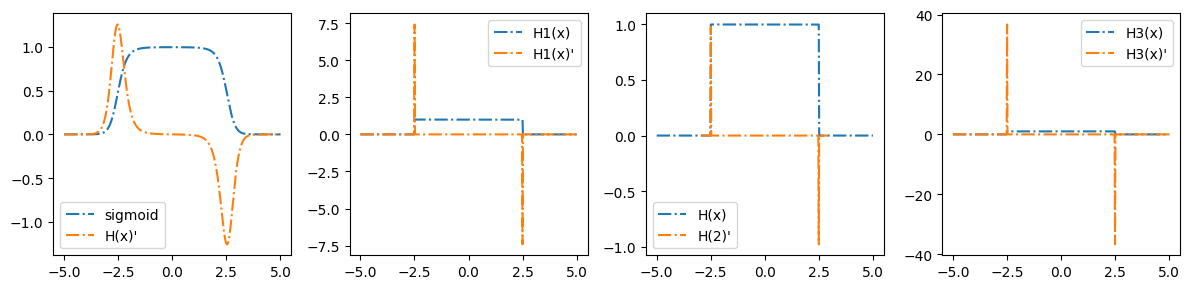

In [122]:
L = 5
N = 512
x0 = torch.linspace(-L, L, N, dtype=torch.float64)
r = torch.as_tensor(L/2)

def diff_heaviside1(x, epsilon=1e2):
    '''
    近似可导函数: https://juejin.cn/s/%E9%98%B6%E8%B7%83%E5%87%BD%E6%95%B0%E6%B1%82%E5%AF%BC
    epsilon 是一个正实数，当 epsilon 趋近于无穷大时，tanh(epsilon*x)近似为阶跃函数
    '''
    return 0.5 * (1 + torch.tanh(x *epsilon))

def diff_heaviside2(x, beta=300):
    return 1 / (1 + torch.exp(-beta * x))


def diff_heaviside3(x, epsilon=1e-2):
    # return torch.sigmoid(2.0 / epsilon * x)
    return torch.sigmoid(x/ epsilon)


fig, ax = plt.subplots(1, 4, figsize=(12, 3), sharey=False)

x= x0.clone().requires_grad_()
y2 = torch.sigmoid((r)**2 - (x**2))
loss = y2.sum()
loss.backward()
ax[0].plot(x.detach().numpy(),y2.detach().numpy(), '-.', label='sigmoid')
ax[0].plot(x.detach().numpy(),x.grad.detach().numpy(), '-.', label='H(x)\'')
ax[0].legend()
print(np.any(np.isnan(x.grad.detach().numpy())))

x= x0.clone().requires_grad_()
y1= diff_heaviside1(r**2-x**2)
loss = y1.sum()
loss.backward()
ax[1].plot(x.detach().numpy(), y1.detach().numpy(), '-.', label='H1(x)')
ax[1].plot(x.detach().numpy(), x.grad.detach().numpy(), '-.', label='H1(x)\'')
ax[1].legend()
print(np.any(np.isnan(x.grad.detach().numpy())))

x= x0.clone().requires_grad_()
y2= diff_heaviside2(r**2-x**2)
loss = y2.sum()
loss.backward()
ax[2].plot(x.detach().numpy(), y2.detach().numpy(), '-.', label='H(x)')
ax[2].plot(x.detach().numpy(), x.grad.detach().numpy(), '-.', label='H(2)\'')
ax[2].legend()
print(np.any(np.isnan(x.grad.detach().numpy())))

x= x0.clone().requires_grad_()
y3= diff_heaviside3(r**2-x**2)
loss = y3.sum()
loss.backward()
ax[3].plot(x.detach().numpy(), y3.detach().numpy(), '-.', label='H3(x)')
ax[3].plot(x.detach().numpy(), x.grad.detach().numpy(), '-.', label='H3(x)\'')
ax[3].legend()
print(np.any(np.isnan(x.grad.detach().numpy())))

fig.tight_layout()
fig.show()

False
False
True
False


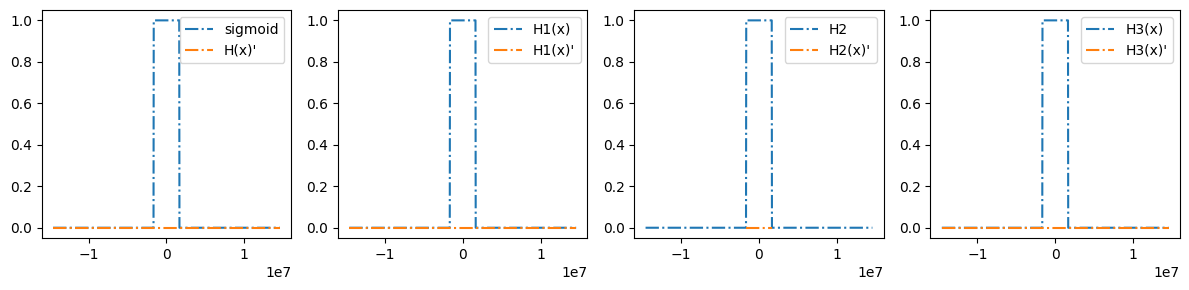

In [125]:
# L = 206
# N = 512
# x = torch.linspace(-L, L, N, dtype=torch.float64)
# r = torch.as_tensor(L/2)


pratio = 4
img_size_lr = 256
img_size_hr = pratio * img_size_lr
wavelength = 532e-9
NA = 0.14
pp_up = 3.45e-6/4
k0 = 2 * np.pi / wavelength
kmax = np.pi / pp_up
r = NA * k0

x0 = torch.linspace(-kmax * pratio, kmax * pratio, img_size_hr, dtype=torch.float64)

def diff_heaviside1(x, epsilon=1e-5):
    '''
    近似可导函数: https://juejin.cn/s/%E9%98%B6%E8%B7%83%E5%87%BD%E6%95%B0%E6%B1%82%E5%AF%BC
    epsilon 是一个正实数，当 epsilon 趋近于无穷大时，tanh(epsilon*x)近似为阶跃函数
    '''
    return 0.5 * (1 + torch.tanh(x *epsilon))


# def diff_heaviside2(x, epsilon=1e+6):
#     return (torch.sign(x) + 1) * 0.5 + (1 - torch.sign(torch.abs(x) - epsilon)) * 0.5


# def diff_heaviside2(x, threshold=0.5):
#     return torch.nn.functional.relu(torch.sign(x - threshold))


def diff_heaviside2(x, beta=5):
    return 1 / (1 + torch.exp(-beta * x))


def diff_heaviside3(x, epsilon=1e+6):
    return torch.sigmoid(2.0 / epsilon * x)
    # return torch.sigmoid(100 * x)


fig, ax = plt.subplots(1, 4, figsize=(12, 3), sharey=False)

x= x0.clone().requires_grad_()
y2 = torch.sigmoid((r)**2 - (x**2))
loss = y2.sum()
loss.backward()
ax[0].plot(x.detach().numpy(),y2.detach().numpy(), '-.', label='sigmoid')
ax[0].plot(x.detach().numpy(),x.grad.detach().numpy(), '-.', label='H(x)\'')
ax[0].legend()
print(np.any(np.isnan(x.grad.detach().numpy())))

x= x0.clone().requires_grad_()
y1= diff_heaviside1(r**2-x**2)
loss = y1.sum()
loss.backward()
ax[1].plot(x.detach().numpy(), y1.detach().numpy(), '-.', label='H1(x)')
ax[1].plot(x.detach().numpy(), x.grad.detach().numpy(), '-.', label='H1(x)\'')
ax[1].legend()
print(np.any(np.isnan(x.grad.detach().numpy())))


x= x0.clone().requires_grad_()
y2= diff_heaviside2(r**2-x**2)
loss = y2.sum()
loss.backward()
ax[2].plot(x.detach().numpy(), y2.detach().numpy(), '-.', label='H2')
ax[2].plot(x.detach().numpy(), x.grad.detach().numpy(), '-.', label='H2(x)\'')
ax[2].legend()
print(np.any(np.isnan(x.grad.detach().numpy())))

x= x0.clone().requires_grad_()
y3= diff_heaviside3(r**2-x**2)
loss = y3.sum()
loss.backward()
ax[3].plot(x.detach().numpy(), y3.detach().numpy(), '-.', label='H3(x)')
ax[3].plot(x.detach().numpy(), x.grad.detach().numpy(), '-.', label='H3(x)\'')
ax[3].legend()
print(np.any(np.isnan(x.grad.detach().numpy())))


fig.tight_layout()
fig.show()

In [12]:
kmax * pratio

14569705.060126577

## Coordinate operations

In [13]:
def xyz_trans(points=[], trans_xyz=[0, 0, 0], rot_xyz=[0, 0, 0], device='cpu'):
    """
    Transform 3D points using a combined translation of trans_xyz and rotation of rot_xyz.

    Args:
        points (torch.Tensor): Input 3D points as a tensor of shape (N, 3).
        trans_xyz (torch.Tensor): Translation vector as a tensor of shape (3,).
        rot_xyz (torch.Tensor): Rotation angles in radians as a tensor of shape (3,).

    Returns:
        torch.Tensor: Transformed 3D points as a tensor of shape (N, 3).
    """

    assert points.shape[1] == 3
    assert trans_xyz.shape == (3,)
    assert rot_xyz.shape == (3,)

    trans_xyz = trans_xyz.to(device=device)
    points = points.to(device=device)

    point_certer = points.mean(dim=0)

    # Center points at the origin
    centered_points = points - point_certer

    # Create the 3D rotation matrix
    rotation_matrix = torch.eye(3, dtype=torch.float64, device=device)
    for j in range(3):
        axis = torch.tensor([0.0, 0.0, 0.0], device=device)
        axis[j] = 1.0
        angle = rot_xyz[j] / 180.0 * torch.pi

        # cross product matrix
        cpm = torch.tensor([[0, -axis[2], axis[1]],
                            [axis[2], 0, -axis[0]],
                            [-axis[1], axis[0], 0]], dtype=torch.float64, device=device)

        # Rodrigues' formula
        rotation_matrix = (torch.eye(3, device=device) + torch.sin(angle) * cpm + (1 - torch.cos(angle)) * (
                    cpm @ cpm)) @ rotation_matrix

    # Apply the rotation
    rotated_points = centered_points @ rotation_matrix

    # Translate the rotated points back to the origin
    transformed_points = rotated_points + point_certer + trans_xyz.unsqueeze(0)

    return transformed_points


############### Test gradient ######################
xyz = torch.rand((15,3), dtype=torch.float64)

trans = torch.tensor([1.0, 2.0, 3.0], dtype=torch.float64, requires_grad=True)
rot = torch.tensor([4.0, 5.0, 6.0], dtype=torch.float64, requires_grad=True)


f = xyz_trans(xyz, trans_xyz=trans, rot_xyz=rot)
f= f.mean()
f.backward()


print(f"Translation Gradients: {trans.grad}")
print(f"Rotation Angles Gradients: {rot.grad}")

Translation Gradients: tensor([0.3333, 0.3333, 0.3333], dtype=torch.float64)
Rotation Angles Gradients: tensor([ 1.1900e-19,  3.4831e-19, -4.2308e-19], dtype=torch.float64)


## Other examples

### Alterative implementation

**Utilize torch.where, torch.zeros_like, etc. to conduct some of the operations.**

Example function $f(x)$
$$
f(x) =
\begin{cases}
 -x, && x<0 \\
x^2, && x>= 0
\end{cases}
$$
is discontinous at $x=0$.

The intutive implementation below is non-differentiable.

In [126]:
import torch

def non_diff_f(x):
    idx = x<0
    x[idx] = -1*x[idx]
    x[~idx] = x[~idx]**2

    return x

############### Test gradient ######################
x = torch.tensor([-2.0, -1.0, 0.0, 1.0, 2.0], requires_grad=True)

y = non_diff_f(x)
loss = y.sum()
loss.backward()

print(y)
print(f"Derivative at x is {x.grad}")

RuntimeError: ignored

This can be solved by the below one

In [127]:
def diff_f(x):
    idx = x<0
    neg_mask = (idx).float()
    pos_mask = (~idx).float()
    neg_part = -1 * x * neg_mask
    pos_part = x**2 * pos_mask
    return neg_part + pos_part

############### Test gradient ######################
x = torch.tensor([-2.0, -1.0, 0.0, 1.0, 2.0], requires_grad=True)

y = diff_f(x)
loss = y.sum()
loss.backward()

print(y)
print(f"Derivative at x is {x.grad}")

tensor([2., 1., 0., 1., 4.], grad_fn=<AddBackward0>)
Derivative at x is tensor([-1., -1.,  0.,  2.,  4.])


Example function $f(x)$

$$
f(x) =
\begin{cases}
\exp(-1/x), && x>0 \\
0, && x<= 0
\end{cases}
$$

This function is infinitely differentiable. It's derivatives in zero are all zero.

In [16]:
def f(x):
    return (-1/x).exp() * (x > 0)

x = torch.tensor(0.0, requires_grad=True)
y = f(x)
y.backward()
x.grad

print(y)
print(f"Derivative at x is {x.grad}")

tensor(0., grad_fn=<MulBackward0>)
tensor(nan)


tensor(0., grad_fn=<SmoothStepBackward>)
Derivative at x is 0.0


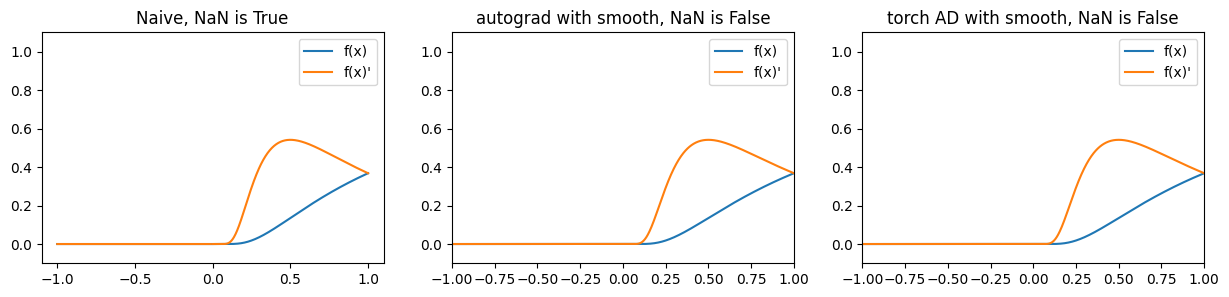

In [129]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3), sharey=False)


def f(x):
    return (-1/x).exp() * (x > 0)


x = torch.linspace(-1, 1, 1000, requires_grad=True)
y0 = f(x)

loss = y0.sum()
loss.backward()

ax[0].plot(x.detach().numpy(), y0.detach().numpy(), '-', label='f(x)')
ax[0].plot(x.detach().numpy(), x.grad.detach().numpy(), '-', label='f(x)\'')
ax[0].set_ylim(-0.1, 1.1)
ax[0].set_title(f'Naive, NaN is {np.any(np.isnan(x.grad.detach().numpy()))}')
ax[0].legend()


############################ SmoothStep ###########################

class SmoothStep(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        y = torch.zeros_like(x)
        m = (x > 0.0)
        y[m] = (-1/x[m]).exp()

        return y

    @staticmethod
    def backward(ctx, dy):
        x, = ctx.saved_tensors
        dx = torch.zeros_like(x)
        m = (x > 0.0)
        xm = x[m]
        dx[m] = (-1/xm).exp() / xm.pow(2)

        return dx * dy

f = SmoothStep.apply

x = torch.linspace(-1, 1, 1000, requires_grad=True)
y0 = f(x)
y1, = torch.autograd.grad(y0.sum(), x, create_graph=True)
assert torch.isfinite(y0).all() and torch.isfinite(y1).all()

ax[1].plot(x.detach().numpy(),y0.detach().numpy(), '-', label='f(x)')
ax[1].plot(x.detach().numpy(),y1.detach().numpy(), '-', label='f(x)\'')
ax[1].set_ylim(-0.1, 1.1)
ax[1].set_xlim(-1, 1)
ax[1].set_title(f'autograd with smooth, NaN is {np.any(np.isnan(y1.detach().numpy()))}')
ax[1].legend()


###################################################################
x = torch.linspace(-1, 1, 1000, requires_grad=True)
y0 = f(x)
loss = y0.sum()
loss.backward()


ax[2].plot(x.detach().numpy(), y0.detach().numpy(), '-', label='f(x)')
ax[2].plot(x.detach().numpy(),x.grad.detach().numpy(), '-', label='f(x)\'')
ax[2].set_ylim(-0.1, 1.1)
ax[2].set_xlim(-1, 1)
ax[2].set_title(f'torch AD with smooth, NaN is {np.any(np.isnan(x.grad.detach().numpy()))}')
ax[2].legend()



x = torch.tensor(0.0, requires_grad=True)
y = f(x)
y.backward()
x.grad

print(y)
print(f"Derivative at x is {x.grad}")

### Subgradient

In [34]:
import torch

class StepFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        # Forward pass logic
        ctx.save_for_backward(input)
        return input.sign()

    @staticmethod
    def backward(ctx, grad_output):
        # Backward pass logic
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < -1] = 0  # Define subgradient at discontinuous points
        grad_input[input > 1] = 0   # Define subgradient at discontinuous points
        return grad_input

# Usage example
x = torch.tensor([0.5, -2.0, 1.5], requires_grad=True)
f_sub = StepFunction.apply

y = f_sub(x)
y.backward(torch.ones_like(y))  # Backpropagation

print("Input Tensor:", x)
print("Output Tensor:", y)
print(f"Derivative at x is {x.grad}")


Input Tensor: tensor([ 0.5000, -2.0000,  1.5000], requires_grad=True)
Output Tensor: tensor([ 1., -1.,  1.], grad_fn=<StepFunctionBackward>)
Gradient: tensor([1., 0., 0.])


In [22]:
import torch

# Example of subgradient calculation
def subgradient(x):
    if x < 0:
        return torch.tensor(-1.0)  # Subgradient at x for a non-differentiable function
    elif x > 0:
        return torch.tensor(1.0)   # Subgradient at x for a non-differentiable function
    else:
        # Any value in [-1, 1] is valid for a subgradient at x = 0
        return torch.tensor([torch.rand(1).item() * 2 - 1])


# Example of proximal operator (e.g., for L1 regularization)
def proximal_operator_L1(x, alpha):
    return torch.sign(x) * torch.max(torch.abs(x) - alpha, torch.tensor(0.0))

# Usage example
x = torch.tensor([-2.0, 1.5, 0.0])
alpha_value = 1.0

# Calculate subgradients for elements in the tensor
subgrad_results = [subgradient(elem) for elem in x]
print("Subgradients:", subgrad_results)

# Apply proximal operator (L1 regularization) to the tensor elements
proximal_result = proximal_operator_L1(x, alpha_value)
print("Proximal operator (L1):", proximal_result)


Subgradients: [tensor(-1.), tensor(1.), tensor([-0.9431])]
Proximal operator (L1): tensor([-1.0000,  0.5000,  0.0000])


In [20]:
import torch

# Define a function with a discontinuity
def f(x):
    return torch.where(x < 0, torch.tensor(0.), torch.sin(x))

# Define the input value
x = torch.tensor(0.0, requires_grad=True)

# Compute the function value
loss = f(x)
loss.backward()

# Access the derivative
print("Derivative at x =", x.item(), "is", x.grad.item())


Derivative at x = 0.0 is 1.0


### reparameterizing

In [33]:
import torch

# Example discontinuous function (step function)
def discontinuous_function(x):
    return torch.where(x >= 0, torch.tensor(1.0), torch.tensor(0.0))

# Smooth approximation using sigmoid function
def smooth_approximation(x):
    return torch.sigmoid(x)

# Test the functions
x_test = torch.tensor([-2.0, -1.0, 0.0, 1.0, 2.0])

result_discontinuous = discontinuous_function(x_test)
result_smooth = smooth_approximation(x_test)

print("Discontinuous Function Result:", result_discontinuous)
print("Smooth Approximation Result:", result_smooth)


Discontinuous Function Result: tensor([0., 0., 1., 1., 1.])
Smooth Approximation Result: tensor([0.1192, 0.2689, 0.5000, 0.7311, 0.8808])


### L1 loss

- https://github.com/pytorch/pytorch/issues/7172
- torch.nn.SmoothL1Loss
Creates a criterion that uses a squared term if the absolute element-wise error falls below beta and an L1 term otherwise. It is less sensitive to outliers than torch.nn.MSELoss and in some cases prevents exploding gradients (e.g. see the paper Fast R-CNN by Ross Girshick).
- https://medium.com/mlearning-ai/understanding-l1-and-smoothl1loss-f5af0f801c71

In [18]:
def reduce(x, reduction="mean"):
    """Batch reduction of a tensor."""
    if reduction == "sum":
        x = x.sum()
    elif reduction == "mean":
        x = x.mean()
    elif reduction == "none":
        x = x
    else:
        raise ValueError("unkown reduction={}.".format(reduction))
    return x


def l1_loss(pred, target, reduction="mean"):
    """Computes the F1 loss with subgradient 0."""
    diff = pred - target
    loss = torch.abs(diff)
    loss = reduce(loss, reduction=reduction)
    return loss


def huber_loss(pred, target, delta=1e-3, reduction="mean"):
    """Computes the Huber loss."""
    diff = pred - target
    abs_diff = torch.abs(diff)
    loss = torch.where(abs_diff < delta,
                       0.5 * diff**2,
                       delta * (abs_diff - 0.5 * delta))
    loss = reduce(loss, reduction=reduction)
    return loss


